In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Data Description
source: https://www.kaggle.com/yash612/covidnet-mini-and-gan-enerated-chest-xray

## Acknowledgements

We wouldn't be here without the help of others.

https://ieeexplore.ieee.org/document/9093842 , Covid GAN  
https://github.com/lindawangg/COVID-Net , COVID-Net  
https://github.com/ieee8023/covid-chestxray-dataset , IEEE dataset  
RSNA dataset  
http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5  

In [ ]:
train_dir = os.path.join("data/chest_xray/chest_xray/train")
validation_dir = os.path.join("data/chest_xray/chest_xray/test")
testing_dir = os.path.join("data/chest_xray/chest_xray/val")

In [ ]:

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 30,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2)

validation_datagen = ImageDataGenerator(rescale = 1./255.)

test_datagen = ImageDataGenerator( rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 32, class_mode='categorical', color_mode='rgb', 
                                                    target_size = (299, 299)) 

validation_generator =  validation_datagen.flow_from_directory(validation_dir, batch_size  = 32,color_mode='rgb',
                                                          class_mode='categorical', 
                                                          target_size = (299, 299))
test_generator =  test_datagen.flow_from_directory(testing_dir, batch_size  = 32, class_mode='categorical', color_mode='rgb', 
                                                   target_size = (299, 299))

Found 5882 images belonging to 3 classes.
Found 635 images belonging to 3 classes.
Found 27 images belonging to 3 classes.


In [ ]:
InceptionV3_model = InceptionV3(include_top=False, weights='imagenet', pooling='avg', input_shape=(299,299,3))
InceptionV3_model.input, InceptionV3_model.output
x=tf.keras.layers.Dense(256, activation='relu')(InceptionV3_model.output)
x=tf.keras.layers.Dense(64, activation='relu')(x)
output_layer = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(InceptionV3_model.input, output_layer)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
___________________________________________________________________________________________

In [ ]:
!rm -r logs/

In [ ]:
from datetime import datetime
log_dir="logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)
# 4. Save your model at every epoch if your validation accuracy is improved from previous epoch.
filepath="model_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
# Saving the model
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_accuracy', save_best_only=True, verbose=1, mode='auto')

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 80,
            epochs = 10,
            validation_steps = 20,
            verbose = 1,
            callbacks=[tensorboard_callback, checkpoint])

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.4731 - accuracy: 0.7950
Epoch 00001: val_accuracy improved from -inf to 0.67717, saving model to model_save/weights-01-0.6772.hdf5
100/100 [==============================] - 175s 2s/step - loss: 0.4731 - accuracy: 0.7950 - val_loss: 0.7178 - val_accuracy: 0.6772
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.2226 - accuracy: 0.9080
Epoch 00002: val_accuracy improved from 0.67717 to 0.83465, saving model to model_save/weights-02-0.8346.hdf5
100/100 [==============================] - 173s 2s/step - loss: 0.2226 - accuracy: 0.9080 - val_loss: 0.4032 - val_accuracy: 0.8346
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.1804 - accuracy: 0.9244
Epoch 00003: val_accuracy improved from 0.83465 to 0.89291, saving model to model_save/weights-03-0.8929.hdf5
100/100 [==============================] - 169s 2s/step - loss: 0.1804 - accuracy: 0.9244 - val_loss: 0.2612 - val_accura


history dict: {'loss': [0.4731036424636841, 0.2225574404001236, 0.18043452501296997, 0.14295834302902222, 0.13642409443855286, 0.13817648589611053, 0.11755739897489548, 0.11074785143136978, 0.10024634748697281, 0.08818085491657257], 'accuracy': [0.7950000166893005, 0.9079524278640747, 0.9243749976158142, 0.9387500286102295, 0.9424999952316284, 0.9411396384239197, 0.9528124928474426, 0.9564809203147888, 0.95835942029953, 0.9668750166893005], 'val_loss': [0.7178003787994385, 0.4032028913497925, 0.2611502408981323, 0.248954176902771, 0.320049524307251, 0.3139122426509857, 0.2348976731300354, 0.24242058396339417, 0.2238277941942215, 0.45353326201438904], 'val_accuracy': [0.6771653294563293, 0.834645688533783, 0.8929134011268616, 0.8992125988006592, 0.8834645748138428, 0.8661417365074158, 0.9102362394332886, 0.9023622274398804, 0.9102362394332886, 0.8803149461746216]}


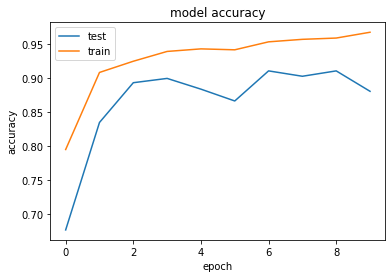

In [82]:
print('\nhistory dict:', history.history)
# summarize history for loss
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['test', 'train'], loc='upper left')
plt.show()

In [84]:
model.load_weights('model_save/weights-07-0.9102.hdf5')

In [85]:
inception_model = InceptionV3(include_top=False, weights='imagenet', pooling='avg', input_shape=(299,299,3))
for i, layer in enumerate(inception_model.layers):
    layer.set_weights(model.layers[i].get_weights())

In [88]:
inception_model.save_weights("trained_weights-07-0.9102.hdf5")

# Training without Imagenet weights

In [90]:
InceptionV3_model_no_wts = InceptionV3(include_top=False, weights=None, pooling='avg', input_shape=(299,299,3))
InceptionV3_model_no_wts.input, InceptionV3_model_no_wts.output
x=tf.keras.layers.Dense(256, activation='relu')(InceptionV3_model_no_wts.output)
x=tf.keras.layers.Dense(64, activation='relu')(x)
output_layer = tf.keras.layers.Dense(3, activation='softmax')(x)
model_2 = tf.keras.Model(InceptionV3_model_no_wts.input, output_layer)
model_2.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 149, 149, 32) 864         input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 149, 149, 32) 96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 149, 149, 32) 0           batch_normalization_376[0][0]    
___________________________________________________________________________________________

In [92]:
!rm -r logs_2/

In [91]:
from datetime import datetime
log_dir="logs_2/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)
# 4. Save your model at every epoch if your validation accuracy is improved from previous epoch.
filepath="model_save_2/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
# Saving the model
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_accuracy', save_best_only=True, verbose=1, mode='auto')

In [93]:
model_2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True), metrics=['accuracy'])
history_2 = model_2.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 10,
            validation_steps = 20,
            verbose = 1,
            callbacks=[tensorboard_callback, checkpoint])

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.6166 - accuracy: 0.7563
Epoch 00001: val_accuracy improved from -inf to 0.61417, saving model to model_save_2/weights-01-0.6142.hdf5
100/100 [==============================] - 168s 2s/step - loss: 0.6166 - accuracy: 0.7563 - val_loss: 1.2320 - val_accuracy: 0.6142
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.5191 - accuracy: 0.7940
Epoch 00002: val_accuracy did not improve from 0.61417
100/100 [==============================] - 165s 2s/step - loss: 0.5191 - accuracy: 0.7940 - val_loss: 2.3692 - val_accuracy: 0.6142
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.4322 - accuracy: 0.8309
Epoch 00003: val_accuracy did not improve from 0.61417
100/100 [==============================] - 166s 2s/step - loss: 0.4322 - accuracy: 0.8309 - val_loss: 2.6709 - val_accuracy: 0.6126
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 0.3837 - accuracy: 0.8478
E

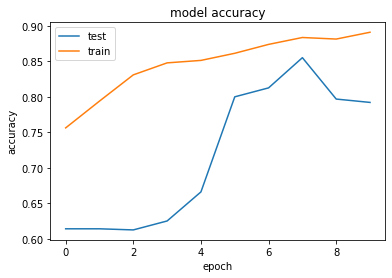

In [96]:
# summarize history for loss
plt.plot(history_2.history['val_accuracy'])
plt.plot(history_2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['test', 'train'], loc='upper left')
plt.show()

 # Conclusion
 - Model did not perform well. without imagenet weights.
 - Lets consider the 1st model trained on imagenet weight initialization.